In [2]:
from huggingface_hub import notebook_login
from PIL import Image
from datasets import load_dataset

notebook_login()

https://huggingface.co/docs/transformers/en/tasks/image_classification#image-classification

https://huggingface.co/docs/datasets/en/image_dataset

## Converting all images to jpg, and also renaming for simplicity

Converting images with broken label to png first, then converting healthy and storing them in different folders so that they can be labeled in metadata.csv

In [4]:
fp = '../classification_dataset/Service'


import os
files = os.listdir(f'{fp}/notworking/')

files
ct = 1
for i in files:
    im = Image.open(f'{fp}/notworking/{i}').convert("RGB")
    im.save(f"{fp}/notworking_conv/broken{ct}.png", "png")
    ct+=1

In [7]:

files = os.listdir(f'{fp}/working/')

files
ct = 1
for i in files:
    im = Image.open(f'{fp}/working/{i}').convert("RGB")
    im.save(f"{fp}/working_conv/healthy{ct}.png", "png")
    ct+=1

c:\Users\dskon\anaconda3\envs\compvision\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [9]:
import csv
healthy = os.listdir(f'{fp}/working_conv/')
broken = os.listdir(f'{fp}/notworking_conv/')
#with open('screen_metadata.csv', newline='') as csvfile:
f = open('charger_metadata.csv','w')
    #csvfile.write('file_name,broken')
f.write('file_name,label')
f.write('\n')
for img in healthy:
        f.write(f'{img}, 0')
        f.write('\n')
for img in broken:
        f.write(f'{img}, 1')
        f.write('\n')
f.close()


In [10]:


dataset = load_dataset("imagefolder", data_dir=f"{fp}/service_dataset")

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [11]:
dataset_identifier = 'charging-charger-classification-dataset'

In [12]:
dataset.push_to_hub(f'dskong07/{dataset_identifier}')

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/65 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/dskong07/charging-charger-classification-dataset/commit/ac0f70a849b9a17a4dba0404c931d97f96e781d2', commit_message='Upload dataset', commit_description='', oid='ac0f70a849b9a17a4dba0404c931d97f96e781d2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/dskong07/charging-charger-classification-dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='dskong07/charging-charger-classification-dataset'), pr_revision=None, pr_num=None)

## Now getting from HF repo and stuff

In [13]:
chargers = load_dataset(f"dskong07/{dataset_identifier}")

README.md:   0%|          | 0.00/315 [00:00<?, ?B/s]

c:\Users\dskon\anaconda3\envs\compvision\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dskon\.cache\huggingface\hub\datasets--dskong07--charging-charger-classification-dataset. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00000-of-00001.parquet:   0%|          | 0.00/168M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/65 [00:00<?, ? examples/s]

In [14]:
chargers = chargers.shuffle(seed=1)
ds = chargers["train"].train_test_split(test_size=0.2)
train_ds = ds["train"]
test_ds = ds["test"]

In [15]:
# images labeled with 0 in the dataset are healthy images, and 1 are broken.
id2label={0:'healthy',1:'broken'}
label2id = {v: k for k, v in id2label.items()}

In [16]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"

image_processor = AutoImageProcessor.from_pretrained(checkpoint, use_fast=True)

c:\Users\dskon\anaconda3\envs\compvision\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [17]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

size = (

    image_processor.size["shortest_edge"]

    if "shortest_edge" in image_processor.size

    else (image_processor.size["height"], image_processor.size["width"])

)

_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [18]:
def transforms(examples):

    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]

    del examples["image"]

    return examples

In [19]:
ds = ds.with_transform(transforms)

In [20]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [21]:
import evaluate

accuracy = evaluate.load("accuracy")

import numpy as np


def compute_metrics(eval_pred):

    predictions, labels = eval_pred

    predictions = np.argmax(predictions, axis=1)

    return accuracy.compute(predictions=predictions, references=labels)

In [22]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer



model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="charger-classif-model",
    remove_unused_columns=False,
    eval_strategy="steps",
    save_strategy="steps",
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=2,
    num_train_epochs=8,
    #warmup_ratio=0.1,
    logging_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=ds['train'],
    eval_dataset=ds['test'],
    processing_class=image_processor,
    compute_metrics=compute_metrics,
)


In [27]:

trainer.train()

Step,Training Loss,Validation Loss,Accuracy
1,0.405700,0.550839,0.692308
2,0.519400,0.573540,0.692308
3,0.414100,0.500660,0.769231
4,0.544200,0.515975,0.846154
5,0.430000,0.593082,0.769231
6,0.412600,0.522797,0.769231
7,0.415100,0.555194,0.769231
8,0.375300,0.582519,0.615385
9,0.346800,0.563710,0.692308
10,0.346700,0.514759,0.692308


Could not locate the best model at charger-classif-model\checkpoint-38\pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


TrainOutput(global_step=104, training_loss=0.2661474290877007, metrics={'train_runtime': 589.4026, 'train_samples_per_second': 0.706, 'train_steps_per_second': 0.176, 'total_flos': 3.223666767967027e+16, 'train_loss': 0.2661474290877007, 'epoch': 8.0})

In [29]:
trainer.push_to_hub()

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/dskong07/charger-classif-model/commit/225a3cd8a6ba18e9901995cbfa775cf45fb3be48', commit_message='End of training', commit_description='', oid='225a3cd8a6ba18e9901995cbfa775cf45fb3be48', pr_url=None, repo_url=RepoUrl('https://huggingface.co/dskong07/charger-classif-model', endpoint='https://huggingface.co', repo_type='model', repo_id='dskong07/charger-classif-model'), pr_revision=None, pr_num=None)

# Testing model inference from HF api

In [30]:
from transformers import pipeline

classifier = pipeline("image-classification", model="charger-classif-model")


#classifier(image)

Device set to use cpu


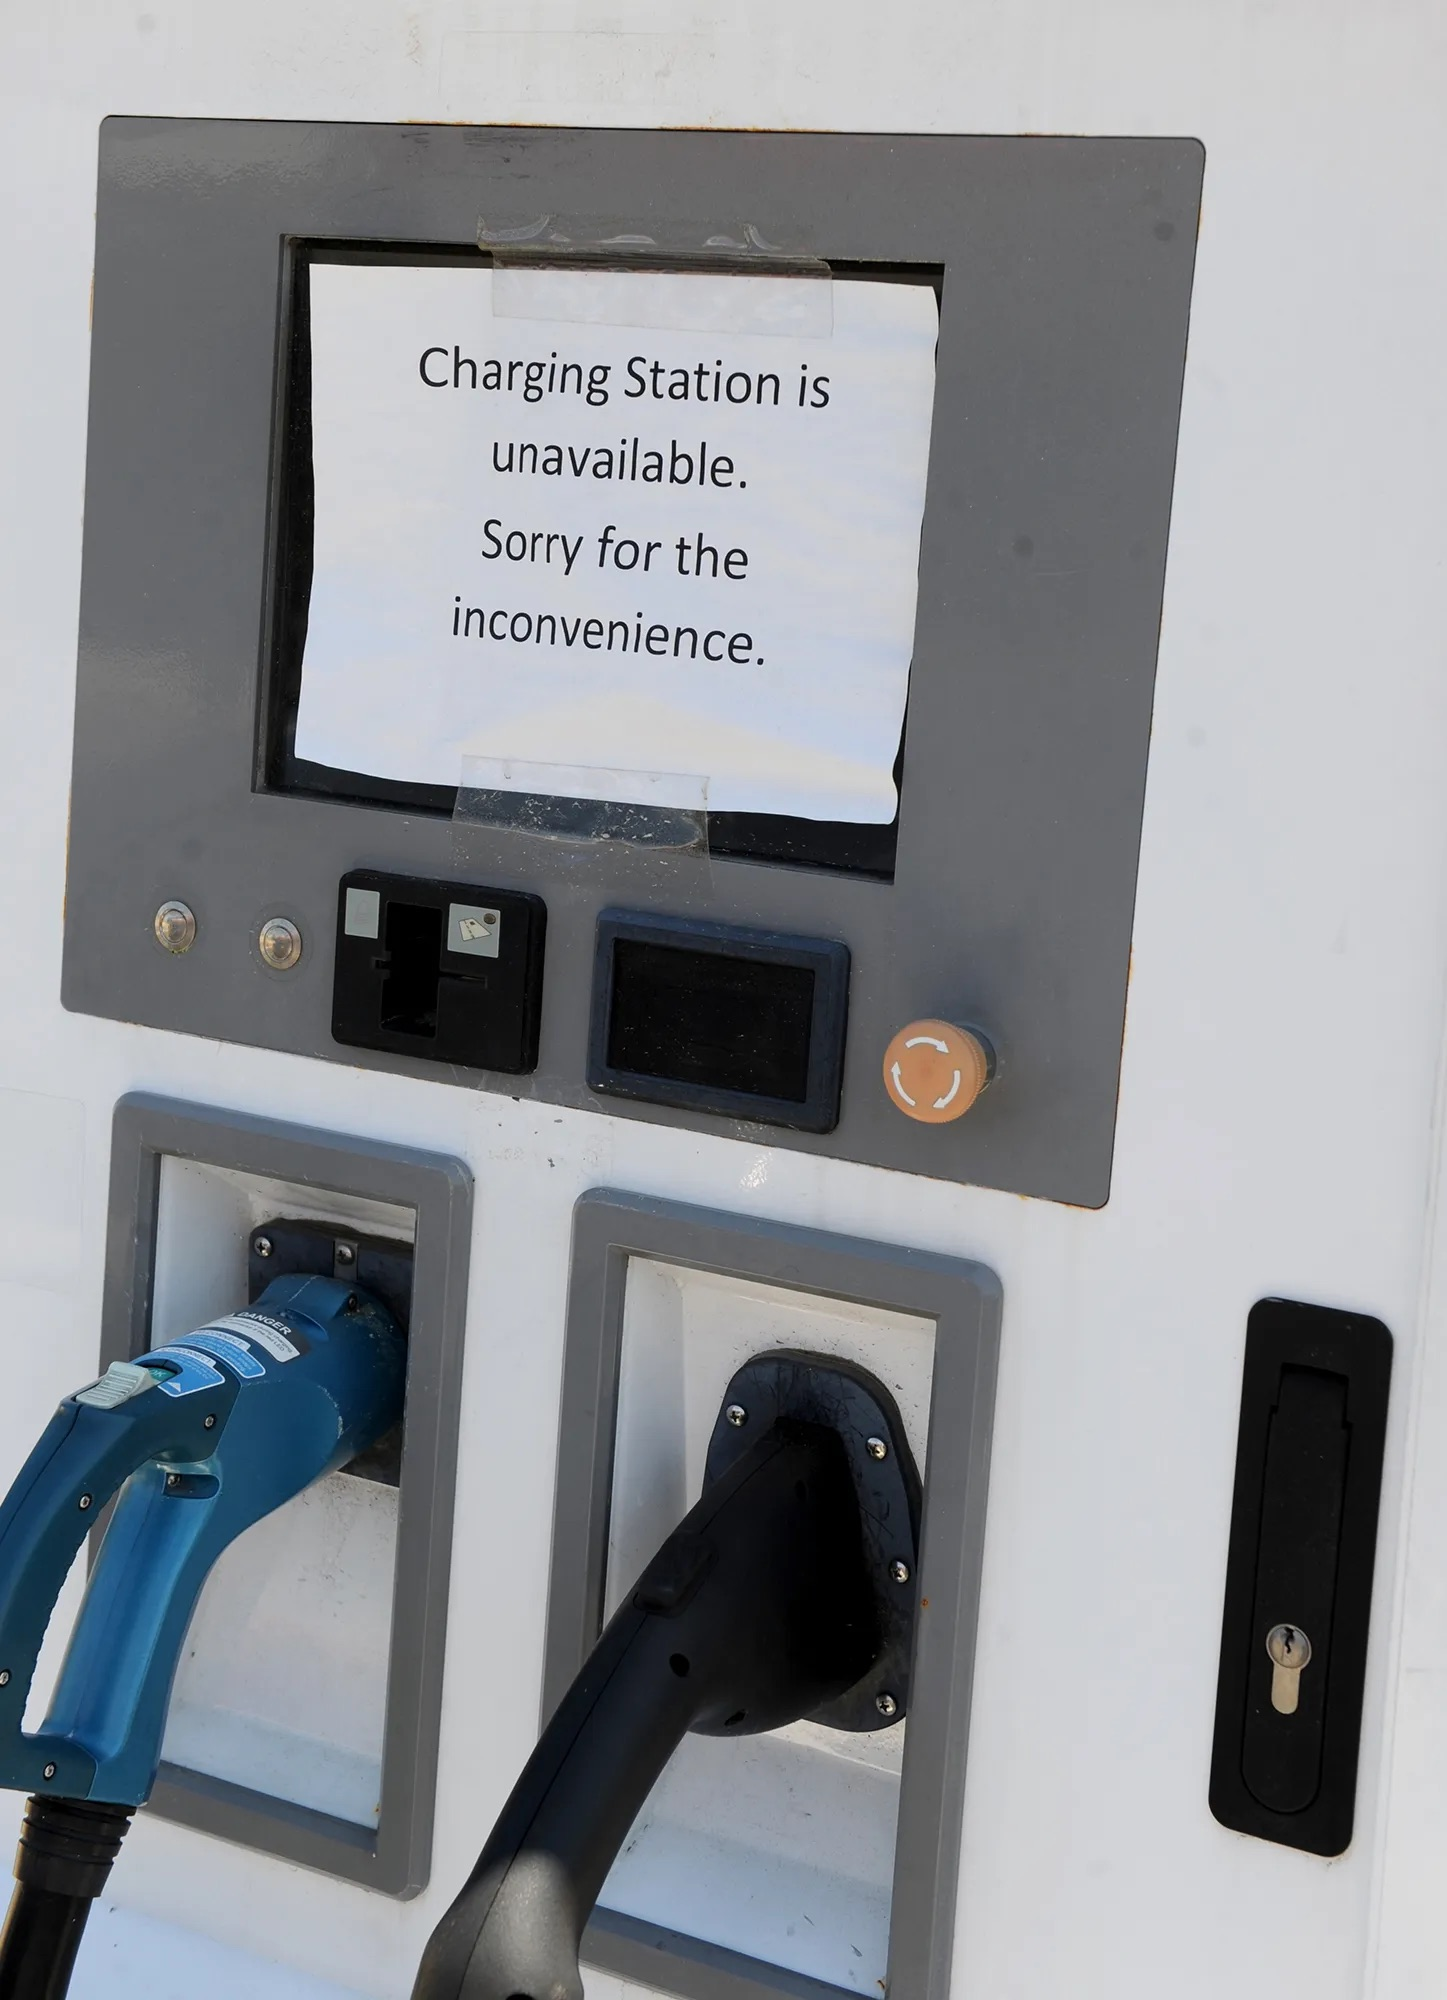

In [31]:
img_test = chargers['train']['image'][0]
img_test

In [32]:
classifier(img_test)

[{'label': 'broken', 'score': 0.7565574049949646},
 {'label': 'healthy', 'score': 0.255965918302536}]

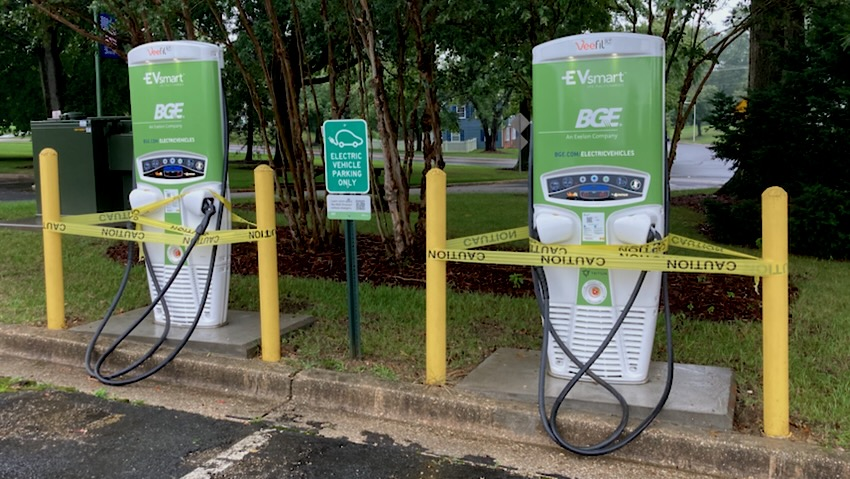

In [ ]:
local_img = Image.open(fp='example_data/brokencharger_example.png')
local_img

In [36]:
classifier(local_img)

[{'label': 'broken', 'score': 0.6027459502220154},
 {'label': 'healthy', 'score': 0.4338098168373108}]